In [1]:
#1 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#2 
dataset = pd.read_csv(r"E:\ImpDocs\CollegeDoc\Machine Learning\New folder (2)\car_price_prediction.csv")
dataset.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
#3 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [4]:
#4 Replace missing values with NaN
dataset = dataset.replace(['-', ' ', '?', 'None'], np.nan)

# Remove duplicates rows from the dataset
dataset.drop_duplicates(inplace=True)

In [5]:
#5 Convert the 'Levy' column to a categorical data type
dataset["Levy"] = dataset["Levy"].astype("category")

# Create a mapping between category codes and original category values
category_map = dict(enumerate(dataset["Levy"].cat.categories))

# Convert categories to numerical codes, replace -1 (missing) with NaN
dataset["Levy"] = dataset["Levy"].cat.codes.replace(-1, np.nan)

# Initialize the Iterative Imputer
imp = IterativeImputer()

# Impute missing values in the 'Levy' column
dataset[["Levy"]] = imp.fit_transform(dataset[["Levy"]])

# Round imputed values and convert them to integers
dataset["Levy"] = dataset["Levy"].round().astype(int)

# Map the numerical codes back to the original category values
dataset["Levy"] = dataset["Levy"].map(category_map)


In [6]:
#6 List of columns that should contain numeric values
numeric_cols = ["Levy", "Prod. year", "Cylinders", "Airbags", "Mileage", "Engine volume"]

# Convert each column to numeric type
# Invalid values will be replaced with NaN
for col in numeric_cols:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

# Ensure 'Mileage' column is stored as float
dataset["Mileage"] = dataset["Mileage"].astype(float)

# Ensure 'Engine volume' column is stored as float
dataset["Engine volume"] = dataset["Engine volume"].astype(float)

In [7]:
#7 handle outliers
for col in ["Levy", "Prod. year", "Cylinders"]:

    # first quartile (Q1)
    Q1 = dataset[col].quantile(0.25)

    # third quartile (Q3)
    Q3 = dataset[col].quantile(0.75)

    # Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outlier detection
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    # Keep only rows where values are within the acceptable range
    dataset = dataset[(dataset[col] >= lower) & (dataset[col] <= upper)]

In [8]:
#8 Remove all numeric characters from the 'Model' column
dataset["Model"] = dataset["Model"].str.replace(r'\d+', '', regex=True)

# Replace empty strings with NaN values
dataset["Model"] = dataset["Model"].replace({'': np.nan})

# Fill missing values with (mode)
dataset["Model"] = dataset["Model"].fillna(dataset["Model"].mode()[0])

In [ ]:
#9 Create new Columns 
#  Calculate car age based on production year
dataset['Car_age'] = 2025 - dataset['Prod. year']

# Calculate average mileage per year (add 1 to avoid division by zero)
dataset['Mileage_per_Year'] = dataset['Mileage'] / (dataset['Car_age'] + 1)

# Calculate mileage relative to engine size (add .1 to avoid division by zero)
dataset['Mileage_per_Engine'] = dataset['Mileage'] / (dataset['Engine volume'] + 0.1)

# Calculate engine volume per cylinder (add .1 to avoid division by zero)
dataset['Engine_per_Cylinder'] = dataset['Engine volume'] / (dataset['Cylinders'] + 0.1)

# Create a factor representing car modernity based on engine size and safety features
dataset['Modernity_Factor'] = dataset['Engine volume'] * dataset['Airbags'] * 0.1

# Create an interaction feature between engine volume and production year
dataset['Engine_Prod_Interaction'] = dataset['Engine volume'] * dataset['Prod. year'] * 0.01

# Create a luxury score based on leather interior, airbags, and engine size
dataset['Luxury_Score'] = (
    dataset['Leather interior'].map({'Yes': 1, 'No': 0}) *
    dataset['Airbags'] *
    (dataset['Engine volume'] / 2.0)
)

In [10]:
dataset.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,...,Wheel,Color,Airbags,Car_age,Mileage_per_Year,Mileage_per_Engine,Engine_per_Cylinder,Modernity_Factor,Engine_Prod_Interaction,Luxury_Score
2,45774419,8467,364,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,...,Right-hand drive,Black,2,19,NaN,NaN,0.317073,0.26,26.078,0.0
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,...,Left wheel,White,0,14,NaN,NaN,0.609756,0.00,50.275,0.0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,...,Left wheel,Silver,4,11,NaN,NaN,0.317073,0.52,26.182,2.6
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2.0,...,Left wheel,White,4,9,NaN,NaN,0.487805,0.80,40.320,4.0
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,...,Left wheel,White,12,15,NaN,NaN,0.439024,2.16,36.180,10.8


In [11]:
#10 List of categorical columns to be label encoded
label_cols = [
    "Category",
    "Leather interior",
    "Fuel type",
    "Gear box type",
    "Drive wheels",
    "Wheel",
    "Color",
    "Doors"
]

# Apply Label Encoding to each categorical column
for col in label_cols:
    dataset[col] = LabelEncoder().fit_transform(dataset[col])


In [12]:
#11 one-hot encoding
onehot_cols = ["Manufacturer", "Model"]

for col in onehot_cols:
    # Apply One-Hot Encoding and return a dense array
    encoded = OneHotEncoder(handle_unknown="ignore", sparse_output=False)\
        .fit_transform(dataset[[col]])

    # Create a DataFrame with meaningful column
    encoded_df = pd.DataFrame(
        encoded,
        columns=OneHotEncoder().fit(dataset[[col]]).get_feature_names_out([col])
    )

    # Concatenate the encoded columns with the original dataset
    dataset = pd.concat(
        [dataset.reset_index(drop=True), encoded_df.reset_index(drop=True)],
        axis=1
    )

    # Drop the original categorical column after encoding
    dataset.drop(col, axis=1, inplace=True)

In [13]:
#12 Fill missing values with median 
dataset.fillna(dataset.median(), inplace=True)

# If any missing values remain (in non-numeric columns)  => fill with 0
dataset.fillna(0, inplace=True)

In [14]:
dataset.head()

,ID,Price,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,...,Model_Yaris SE,Model_Yaris iA,Model_Zafira,Model_Zafira B,Model_i,Model_iA isti,Model_kona,Model_macan,Model_tC,Model_xD
0,45774419,8467,364,2006,3,0,4,1.3,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45769185,3607,862,2011,4,1,2,2.5,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,45809263,11726,446,2014,3,1,4,1.3,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45802912,39493,891,2016,4,1,1,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,45656768,1803,761,2010,3,1,2,1.8,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#13 Define the feature (all columns except the target)
X = dataset.drop("Price", axis=1)

# Define the target variable
y = dataset["Price"]

In [16]:
#14 Split the dataset into training and testing sets 
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

# Initialize a StandardScaler 
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test data using the same scaler
x_test_scaled = scaler.transform(x_test)

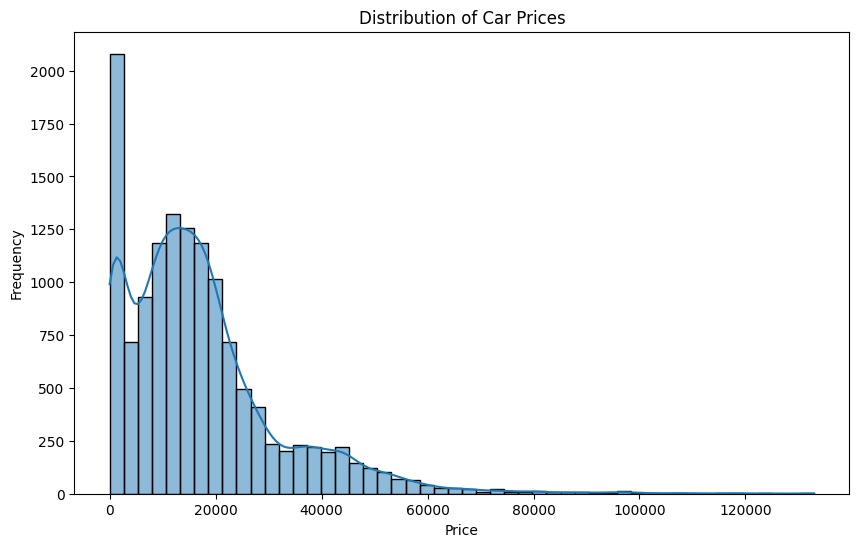

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Price'], bins=50, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [18]:
#15 Initialize the Random Forest Regressor with custom hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=600,         # num of trees in the forest
    max_depth=37,             # maximum depth of each tree
    min_samples_leaf=12,      # minimum samples required at a leaf node
    min_samples_split=15,     # minimum samples required to split a node
    random_state=42,          # for reproducibility
    n_jobs=-3                 # use all CPU cores except 2 for parallel processing
)

# Train the Random Forest model on training data
rf_model.fit(x_train_scaled, y_train)

# Predict target values on test data
y_pred = rf_model.predict(x_test_scaled)

In [19]:
#16 Evaluate the Random Forest model

# R-squared score on the training set
print("Train R2:", rf_model.score(x_train_scaled, y_train))

# R-squared score on the test set
print("Test R2:", rf_model.score(x_test_scaled, y_test))

# Mean Squared Error on the test set
print("MSE:", mean_squared_error(y_test, y_pred))

# Root Mean Squared Error on the test set
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Train R2: 0.8117637678828193
Test R2: 0.8041332221526043
MSE: 40116695.62741319
RMSE: 6333.7742008547475


In [20]:
#17 Create a DataFrame showing feature importance from the trained Random Forest
feature_importance = pd.DataFrame({
    'feature': x_train.columns,            # Feature names
    'importance': rf_model.feature_importances_  # Importance values
}).sort_values('importance', ascending=False)  # Sort descending by importance

# Display the top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                    feature  importance
21             Luxury_Score    0.194591
15                  Car_age    0.151039
2                Prod. year    0.150677
5                 Fuel type    0.086872
20  Engine_Prod_Interaction    0.077067
0                        ID    0.063595
9             Gear box type    0.046657
1                      Levy    0.042086
19         Modernity_Factor    0.041712
3                  Category    0.035810


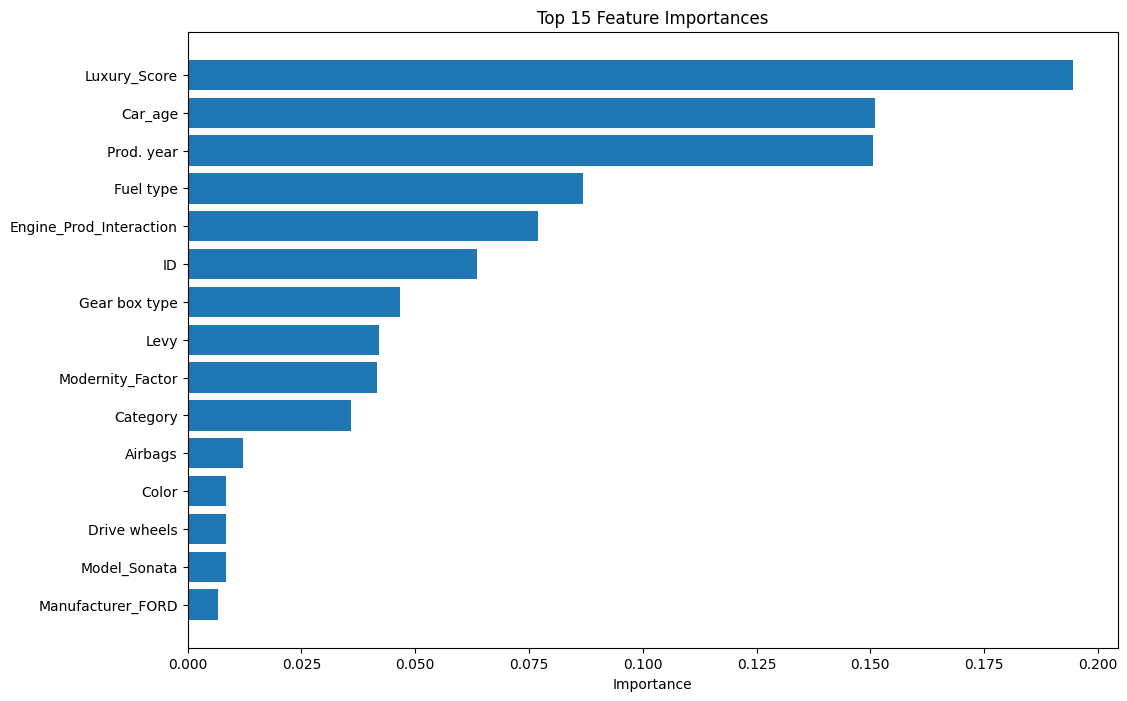

In [21]:
#18 Plot the top 15 feature importances using a horizontal bar chart
plt.figure(figsize=(12, 8))
# Select top 15 features
top_features = feature_importance.head(15)
# Create horizontal bar plot
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

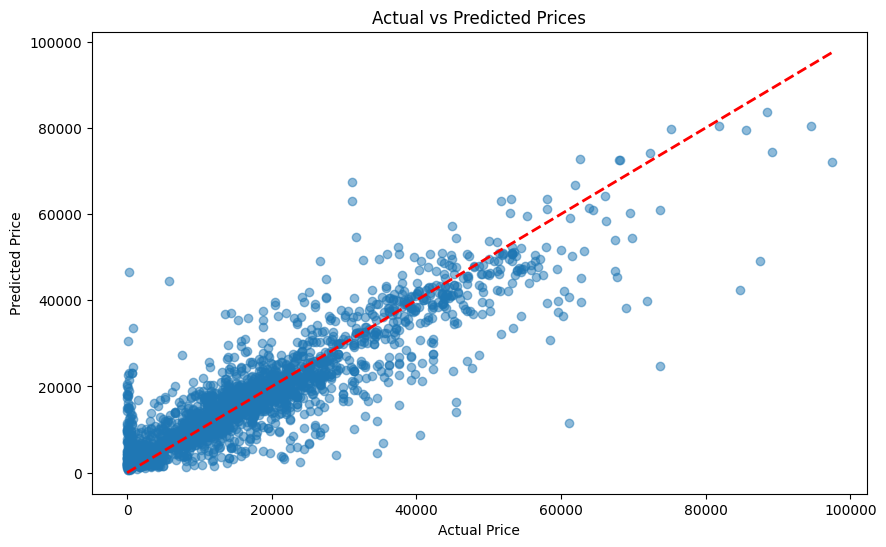

In [ ]:
#19 Plot Actual vs Predicted Prices for the test set
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Add labels and title
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

In [ ]:
#20 Ridge model
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale training data
X_test_scaled = scaler.transform(X_test)        # Scale test data using same scaler

# Initialize the Ridge regression model
ridge_model = Ridge(
    alpha=1.0,       # Regularization strength (can be tuned)
    random_state=42,
    max_iter=10000   # Ensure convergence
)

# Train the Ridge model
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model performance
print("Ridge Test R2:", r2_score(y_test, y_pred))
print("Ridge MSE:", mean_squared_error(y_test, y_pred))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Ridge Test R2: 0.521616882460112
Ridge MSE: 97980628.11138389
Ridge RMSE: 9898.516460125926
